# 競馬において、各馬の実績はレース結果に影響するのか？

使用するデータは、 http://www.netkeiba.com/ の2006/1/1から2018/3/18までのレースデータをスクレイピングしてお借りした。

## 分析の目的
競馬の勝敗予測は様々な研究や方法が開発されている。
- 1着、複勝予想（二値分類問題）
- 順位予想（他クラス分類問題）
- 走破タイム、速度予想（回帰問題）
など

中でもCNNが得意とする分類問題の中でもシンプルな二値分類問題について考えていく。

前提として、予測に使用するデータは出走前に把握することのできる指標を選定。  
使用するデータは過去に出走経験のある馬が出場できる「９レース目」以降のデータで予測することとする。

## 仮説
過去の成績によって強さが決まるのなら、**特定の特徴を持った馬**が優先的に勝利するのではないか、という仮説のもと検証を行う。  
また、その**特定の特徴**がどのようなものなのか把握できないため、CNNで学習させてみることとする。  

優先的に勝利するということは、上位に入賞することと仮定し、今回は3位以内に入賞する  
つまり複勝圏内に入るかどうかを予測して検証を行う。

## 指標
予測に使用する指標は出走前の情報と、過去の実績を使用する。  
この時、当該レースの結果を示す指標は入れないように注意する。  

また、例外として単勝オッズ（人が分析した結果を反映していると仮定）を説明変数に入れる。

| 特徴量名 | カラム名 | 説明 |
|:-----------|------------|------------|
| 単勝オッズ    | win     | 馬券の倍率      |
| 出走回数    | cnt_cumsum     | 過去の出走回数      |
| 1位率    | x1st_ratio_lag     | 過去1位だった割合      |
| 2位率    | x2nd_ratio_lag     | 過去2位だった割合      |
| 3位率    | x3rd_ratio_lag     | 過去3位だった割合     |
| 3位内率    | nyusho_ratio     | 過去3位以内だった割合      |
| 複勝率    | x1st_and_2nd_ratio     | 過去1位もしくは2位だった割合     |
| 休息期間    | last_date_diff     | 出走日-過去のレース日      |
| 前回の走破タイム    | race_time_index_normalize_lag     | 走破タイムをレース毎に正規化      |
| 前回1位    | order_of_arrival_lag_1     | 1=1位, 0=それ以外      |
| 前回2位    | order_of_arrival_lag_2     | 1=2位, 0=それ以外     |
| 前回3位    | order_of_arrival_lag_3     | 1=3位, 0=それ以外     |
| 前回の着差    | wearing_diff_lag_1     | 1位とのタイム差      |
| 過去3回の着差    | wearing_diff_ave_3     | 過去3回の着差の平均      |
| 休息期間の平均    | wearing_diff_ave_sumple     | 休息期間の平均      |
| 前回と同じ騎手    | is_jockey_some     | 1=同じ, 0=それ以外      |


In [54]:
import os
import re
import time

import numpy as np
import pandas as pd
import scipy as sp
from pandas import DataFrame, Series

from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras import metrics

data = pd.read_csv("/root/userspace/homework/race_raw.csv",low_memory=False, header=0)
data = data[data.round_name >= 9]

## データの前処理
今回使用するデータだけのDFを作成し、トレーニング用のデータ（train_X, train_y）とテスト用のデータ（test_X, test_y）を準備する。


In [55]:
# data.columns

In [106]:
def load_data():
    Y = np.eye(2)[data["below_is_3"].values.astype('int32').flatten()]
    X = data[['win', 'cnt_cumsum', 'x1st_ratio_lag',
           'x2nd_ratio_lag', 'x3rd_ratio_lag', 'nyusho_ratio',
           'x1st_and_2nd_ratio', 'last_date_diff', 'race_time_index_normalize_lag',
           'order_of_arrival_lag_1', 'order_of_arrival_lag_2',
           'order_of_arrival_lag_3', 'wearing_diff_lag_1', 'wearing_diff_ave_3',
           'wearing_diff_ave_sumple', 'is_jockey_some']]
    # print(Y)
    # print(len(X.columns))
    train_X, test_X, train_y, test_y = train_test_split(X, Y,
                                                        test_size=10000)
    return (train_X, test_X, train_y, test_y)


## 学習
前処理を行ったデータに対して学習を行う。  
今回は時系列である「血統」や「馬の成長」は考慮せずCNNでモデルを作成する。

In [107]:
def homework(train_X, train_y):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, Dropout, BatchNormalization
    import matplotlib.pyplot as plt
    from keras import backend as K
    
    train_X, valid_X, train_y, valid_y = train_test_split(
    train_X, train_y, test_size=1000)
    print(train_X.shape)

    model = Sequential()
    
    model.add(Dense(256, input_shape=(16,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        
    history = model.fit(train_X, train_y, batch_size=144, verbose=0, epochs=100, validation_data=(valid_X, valid_y))
        
    #Accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    #loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

(24925, 16)


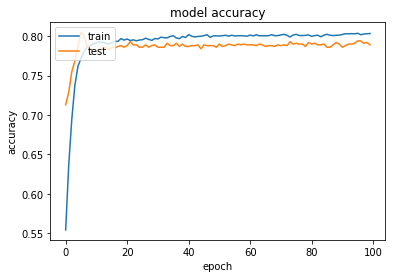

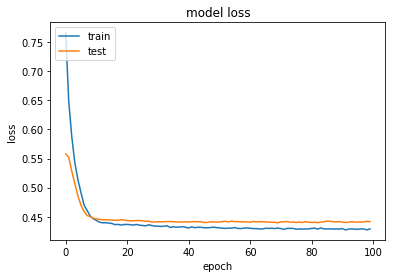

経過時間： 2.0 分


In [108]:
global test_X, test_y, pred_y
train_X, test_X, train_y, test_y = load_data()
t1 = time.time() 

model = homework(train_X, train_y)

t2 = time.time()
elapsed_time = t2-t1
print("経過時間：", elapsed_time//60, "分")


In [115]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

pred_y = model.predict(test_X)
pred_y = np.argmax(pred_y, 1)
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [110]:
#model.save('keiba_cnn.h5')

## 汎化性能の評価
学習したモデルを使用してテスト用のデータで予測を行う。

In [111]:
print(f1_score(np.argmax(test_y, 1), pred_y, average='macro'))

0.587214891041


結果を見るに、約50%の確率で予測が当たるらしい。

## 混同行列
今回の問題は、3位圏内に入る馬を予測するということなのだが、  
全て3位圏内に入らないと予測されている可能性も考慮する必要がある。  

競馬において、最大の目的は「買った馬券が当たる」ことなので、  
混同行列に置いて、True Positiveがどのくらいの割合なのかを検証してみる。

この場合、1=3位になるなので、`c_matrix[1][1]`の割合を計算する。

In [112]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(np.argmax(test_y, 1), pred_y)
print(c_matrix)
print(c_matrix[1][1]/(c_matrix[0][1]+c_matrix[1][1]))

[[7610  195]
 [1790  405]]
0.675


この場合、混同行列でいう「正解ラベルが陽性」だけを見れば良いので、下記の計算をすることができる。  
また、今回予測した複勝というのは約８割が1−2倍の配当であるため、下記の計算をするとほとんど利益が出ないことが予想される。  
つまりモデルは良い結果では無いということがわかった。

In [114]:
# 利益 100-200の平均-コスト(100円)と仮定すると約50円の利益が期待される
(c_matrix[1][1]*50)-(c_matrix[0][1]*100)

750

## 考察
なぜこのような結果になったのか、自分なりに考察して見る。
- 正解ラベルが少なすぎた
    - レースは15−18頭で行うものなので、圧倒的に正解ラベルが少なく、モデルがなるべく買わない方向に学習してしまったのではないか
- 予測する対象がレース毎ではなく、馬毎だった
    - 今回のように各馬毎に予測を行うと、全データの中では入賞圏内の実力にも関わらず、馬同士の実力が拮抗していたために負けてしまうということが発生していたのではないか
- 説明変数の選定が甘かった
    - ランダムフォレスト、ロジスティック回帰の変数重要度などで仮説検証をする必要がある。
- モデルの設計が甘かった
    - CNNを選定したことや、ハイパーパラメータの設定について、理解が及んでいない部分があったため良い結果が得られなかったのではないか
    
つまりデータとモデルの理解が足りていなかったことがわかる。    
また、レース毎の相対的な実力差から順位を予想していなかったことから、実力の絶対値ではなく、レース毎に相対的な実力を算出するべきだったということがわかった。

**以上のことから、今回の仮説である「各馬の絶対値による差はあるのか」という問いに対して正確に答えることができなかった。**  

今回のこのモデルは「各馬の絶対値による差はあるのか」ではなく、「どんな状況でも勝利できる馬の特徴はあるのか」という問いだったことがわかった。  
そしてそんな馬はいないということが結果から推察できる。

## 反省
今回の反省は、データを取得するスクリプトを作成するのにかなりの時間を費やしてしまったがために、モデルの設計や改善が疎かになってしまったことだ。  
また、今回の課題では満足に着手できなかったので、次回チャレンジする際には下記の項目を考慮したモデルを構築したい。
- 血統（遺伝アルゴリズム）
- 期待値を元にした「意思決定」を含めた予測
- 馬の特徴を元にした距離適性や馬場の相性予測
- 騎手と馬の相性を元にした総合評価
- 他の機械学習手法を比較分析したモデルの解釈

参考  
- https://alphaimpact.jp/2017/05/04/perceptron/  
- http://sleeping-micchi.hatenablog.com/entry/2016/09/15/004221  
- http://www.umameshi.com/info/%E7%AB%B6%E9%A6%AC-%E8%A4%87%E5%8B%9D-%E5%B9%B3%E5%9D%87%E9%85%8D%E5%BD%93-%E3%82%AA%E3%83%83%E3%82%BA-%E8%A6%8B%E6%96%B9-%E4%BB%95%E7%B5%84%E3%81%BF.html  
- https://keras.io/ja/metrics/#_1